<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Linearity Ramp Corrected Residuals

### Table of Contents
<div style="text-align: left"> 

<br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [Run Linearity Pipeline Step](#pipeline_ID) <br> [Calculate Residuals and Display](#residual_ID) <br> 

</div>

<a id="intro_ID"></a>
# Introduction

The linearity step applies the “classic” linearity correction adapted from the HST WFC3/IR linearity correction routine, correcting science data values for detector non-linearity. The correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure. 

For more details, visit the documentation here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html


### Defining Term

JWST: James Webb Space Telescope

OUT: Other Useful Terms

[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports

* astropy.io for opening fits files
* jwst.datamodels for building model for JWST Pipeline
* jwst.linearity.LinearityStep to perform the linearity pipeline correction
* matplotlib.pyplot.plt to generate plot
* numpy for array parsing and masking
* os for operating system commands.

* matplotlib inline for plot rendering in notebook

[Top of Page](#title_ID)

In [1]:
from astropy.io import fits
from jwst.datamodels import MIRIRampModel
from jwst.linearity import LinearityStep
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

<a id="data_ID"></a>
# Getting the Data

The data we are using for this test is an uncalibrated MIRI image from cryovac testing. List other interesting features about why this dataset was chosen for testing.

Mention something about artifactory... Or how or where we store and access data.

[Top of Page](#title_ID)

In [2]:
# fits_input = fits.open(os.path.join(os.getenv("HOME"), 'jw11173001001_01101_00004_MIRIMAGE_uncal.fits'))

# size of integration
ramps = 1
ngroups = 10
xsize = 1032
ysize = 1024

# create a JWST datamodel for MIRI data
im = MIRIRampModel((ramps, ngroups, ysize, xsize))
im.data = np.random.rand(ramps, ngroups, ysize, xsize)*1e10
im.groupdq = np.random.choice([0, 1], size=(ramps, ngroups, ysize, xsize), p=[7./10, 3./10])
# set file header values
im.meta.instrument.detector = 'MIRIMAGE'
im.meta.instrument.name = 'MIRI'
im.meta.observation.date = '2018-01-01'
im.meta.observation.time = '00:00:00'
im.meta.subarray.xstart = 1
im.meta.subarray.xsize = xsize
im.meta.subarray.ystart = 1
im.meta.subarray.ysize = ysize

<a id="pipeline_ID"></a>
# Run Linearity Pipeline Step

Define the output file and run the linearity correction step of the pipeline.

[Top of Page](#title_ID)

In [3]:
# run pipeline
try:
    outfile = LinearityStep.call(im)
except SystemExit as e:
    print(e)

2019-05-09 13:22:16,974 - stpipe.LinearityStep - INFO - LinearityStep instance created.


2019-05-09 13:22:17,025 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<MIRIRampModel(1, 10, 1024, 1032)>,).


2019-05-09 13:22:17,185 - stpipe.LinearityStep - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2019-05-09 13:22:17,566 - stpipe.LinearityStep - INFO - Step LinearityStep done


<a id="residual_ID"></a>
# Calculate Residuals and Display

Calculate the second difference of the linearity corrected ramp for each 
pixel. If the ramp is perfectly linear they should be zero.

[Top of Page](#title_ID)

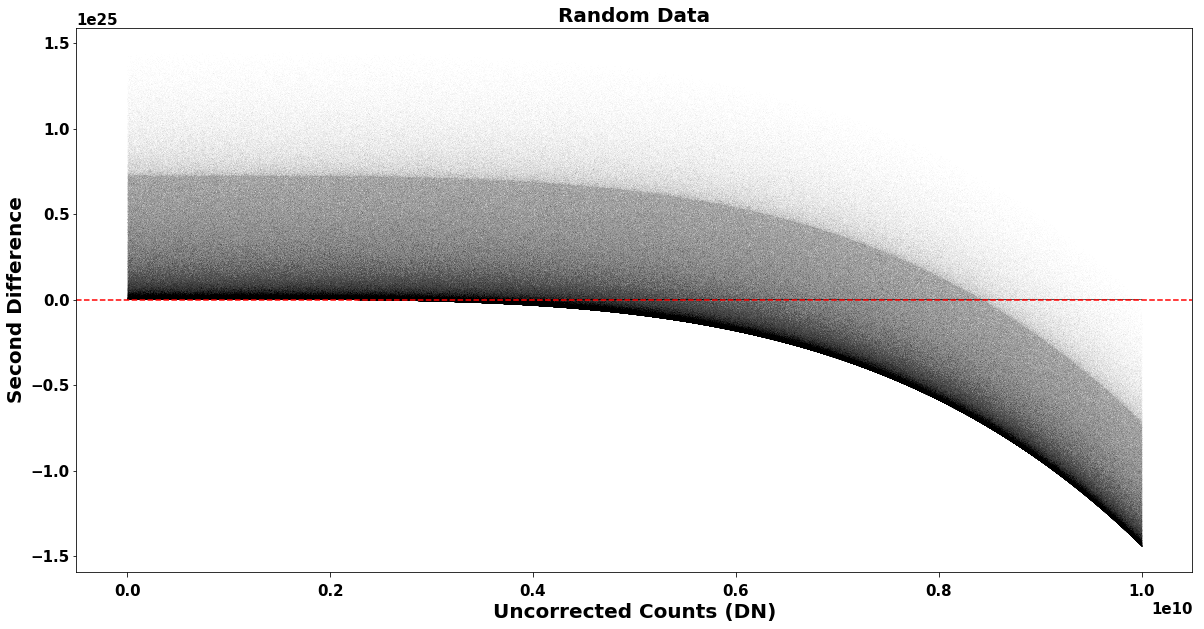

In [4]:
# Get data shape
nints, ngroups, nx, ny = outfile.data.shape
data_by_pixel = outfile.data.reshape(nints, ngroups, nx * ny)

groupdq_by_pixel = outfile.groupdq.reshape(nints, ngroups,
                                           nx * ny)

masked_output = np.ma.array(data_by_pixel, mask=groupdq_by_pixel.astype(bool))
masked_input = np.ma.array(im.data.reshape(nints, ngroups, nx * ny),
                           mask=groupdq_by_pixel.astype(bool))
second_diff = np.ma.diff(masked_output, n=2, axis=1)

# Set plot params
plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.figure(figsize=(20,10))
plt.title('Random Data', fontsize=20, fontweight='bold')

plt.plot(masked_input.data[0, 1:-1, :].flatten(),
         second_diff.data[0, :, :].flatten(), ',k', alpha=.01)

plt.axhline(y=0.0, color='r', ls='--')

plt.ylabel('Second Difference', fontsize=20, fontweight='bold')
plt.xlabel('Uncorrected Counts (DN)', fontsize=20, fontweight='bold')

plt.show()

<a id="about_ID"></a>
## About this Notebook
**Author:** Mees Fix, RIA MESA Branch
<br>**Updated On:** 02/06/2019

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 